In [39]:
import json
import pandas as pd
%matplotlib inline
from pandas.io.json import json_normalize

def load_json(input_path):
    json_list = json.load(open(input_path))
    return pd.DataFrame.from_dict(json_normalize(json_list), orient='columns')

In [40]:
from sklearn.model_selection import train_test_split
df = load_json('whats_cooking/train.json')
df.head()

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."


The data contains 3 columns: cuisine, recipe id (we can ignore that since it's not useful) and lists of ingredients.

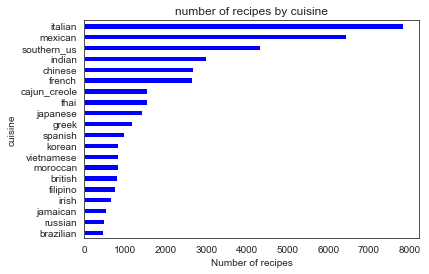

In [41]:
df.groupby('cuisine')['id'].nunique().sort_values(). \
plot(kind='barh',color='blue').set_title('number of recipes by cuisine')
plt.xlabel('Number of recipes')

There are more sample in certain cuisine types such as Italian (nearly 8000) and fewer in certain others such as Brazilian (less than 500).

The target variable to predict is the cuisine type. 

While there is no missing data, I'll do some cleaning on the text to avoid an unnessarily sparse matrix. Later on I'll remove some unnecessary words in the parenthesis such as (1% reduced milk) or (2% reduced milk). 

I will use one-vs-rest logistic regression because it's widely used, relatively easy to explain and later on returned decent result.

For evaluation metrics, I will use macro-F1 score (the average precision and recall for each class label). Because it's a multi-class with unbalanced sample size, I do not want to bias towards the majority class such as Italian, so I use macro-F1.

I'll use 5-fold cross-validation which can be better at reducing variance than simple train/test split.

In [42]:
#text
from sklearn.feature_extraction.text import TfidfVectorizer
#classifier
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
#performance
from sklearn.model_selection import cross_validate

In [43]:
X_df = df['ingredients']
y_df = df['cuisine']

I preprocessed the text using tfidf to identify the uniqueness of ingredients among each cuisine.

In [44]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
import re

#split to pre-process text 
vect = TfidfVectorizer(tokenizer=lambda x: [re.sub(r'\(.*?\)','',i).strip() for i in x.split(',')], 
                       lowercase=False, stop_words='english')

#then join to fit transform strings
dummies = vect.fit_transform(X_df.apply(','.join)) 

df_transformed = pd.DataFrame(dummies.todense(),columns=vect.get_feature_names())
print("Vocab Length: ", len(vect.get_feature_names()))
print("All Data Shape: ", df_transformed.shape)
print("Number of Predictors: ", df_transformed.shape[0])
df_transformed.head()

Vocab Length:  6713
All Data Shape:  (39774, 6713)
Number of Predictors:  39774


,,1 inch thick,1% low-fat buttermilk,1% low-fat chocolate milk,1% low-fat cottage cheese,1% low-fat milk,2 1/2 to 3 lb. chicken,2% low fat cheddar chees,2% low-fat cottage cheese,2% lowfat greek yogurt,...,yukon gold potatoes,yuzu,yuzu juice,za'atar,zest,zesty italian dressing,zinfandel,ziti,zucchini,zucchini blossoms
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
print(df_transformed.shape, y_df.shape)

(39774, 6713) (39774,)


In [46]:
model = LogisticRegression(multi_class= 'ovr')
score = cross_validate(model, df_transformed, y_df, cv=5, return_train_score=False)
score

{'fit_time': array([ 11.82908106,  10.22344494,   8.36979103,   7.28031087,   6.36447096]),
 'score_time': array([ 0.97562599,  0.94243193,  0.978163  ,  0.204319  ,  0.22437   ]),
 'test_score': array([ 0.76312484,  0.7729329 ,  0.76382604,  0.76443215,  0.76758525])}

In [47]:
score['test_score'].mean()

0.76638023663025934

In [48]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold, cross_val_score
labels=y_df.unique()
labels
y_pred = cross_val_predict(model, df_transformed, y_df, cv=5)
conf_mat = confusion_matrix(y_df, y_pred, labels)
cm_df = pd.DataFrame(conf_mat,
                     index = labels, 
                     columns = labels)

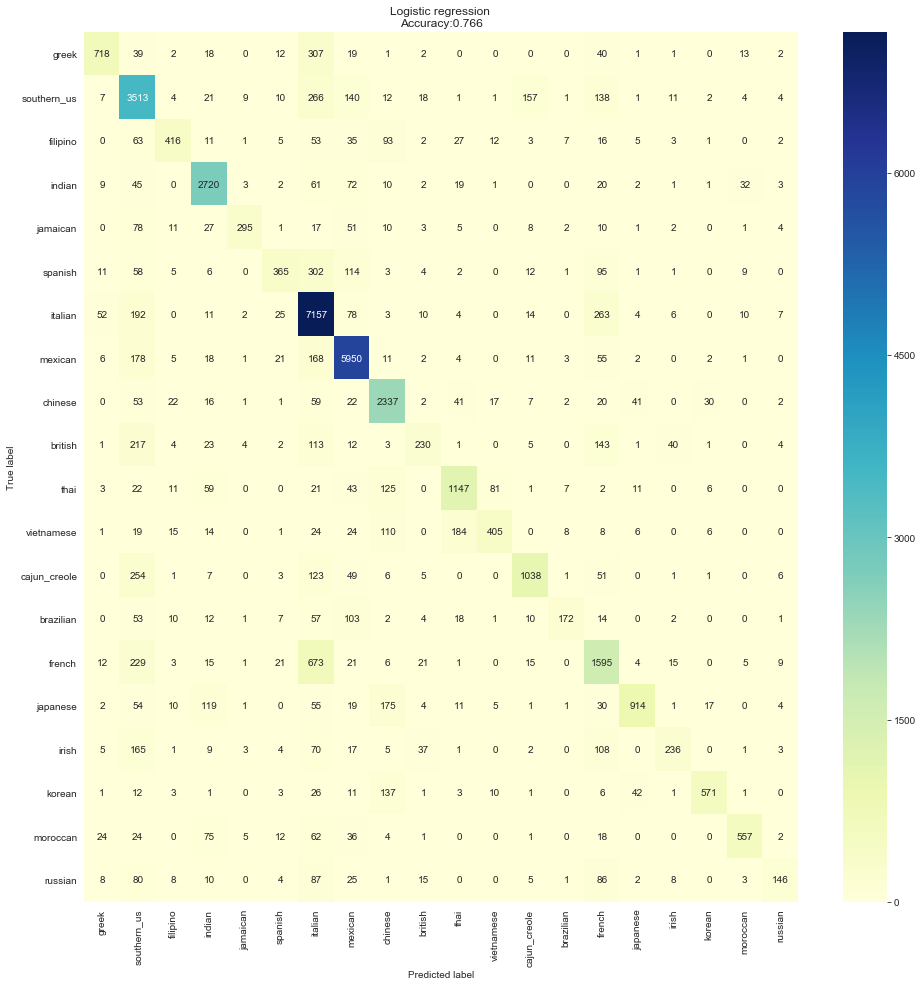

In [49]:
#plot multi-class confusion matrix
plt.figure(figsize=(16,16))
ax=sns.heatmap(conf_mat, annot=True, cmap="YlGnBu", xticklabels=labels, yticklabels=labels, fmt='d')
plt.title('Logistic regression \nAccuracy:{0:.3f}'.format(score['test_score'].mean()))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Based on the confusion matrix, we can tell majority of the predictions end on the diagnoal which means correct classification. However, we also notice certain misclassification such as French or Spanish cuision misclassified as Italian or Cajun Creole misclassified as Southern US. There are indeed some similarity between these cusine types, possibly due to geographical proximity and diaspora. 

Next we look into some example of the misclassified cases, including the misclassified categories we identified from the confusion matrix.

In [50]:
#index for misclassified items
idx=np.where(y_df!=y_pred)
misclassification=pd.concat([pd.DataFrame(y_pred).iloc[idx],pd.DataFrame(y_df).iloc[idx],X_df.iloc[idx]], axis=1)
misclassification.columns=['predicted','actual','ingredients']
misclassification.head(10)

,predicted,actual,ingredients
5,southern_us,jamaican,"[plain flour, sugar, butter, eggs, fresh ginge..."
6,mexican,spanish,"[olive oil, salt, medium shrimp, pepper, garli..."
14,french,italian,"[fresh parmesan cheese, butter, all-purpose fl..."
16,italian,british,"[greek yogurt, lemon curd, confectioners sugar..."
18,vietnamese,thai,"[sugar, hot chili, asian fish sauce, lime juice]"
19,chinese,vietnamese,"[soy sauce, vegetable oil, red bell pepper, ch..."
22,italian,southern_us,"[low-fat mayonnaise, pepper, salt, baking pota..."
23,thai,chinese,"[sesame seeds, red pepper, yellow peppers, wat..."
26,indian,cajun_creole,"[herbs, lemon juice, fresh tomatoes, paprika, ..."
30,southern_us,italian,"[yellow corn meal, boiling water, butter, fres..."


In [51]:
#japanese misclassified as chinese food
jp_cn = (misclassification['predicted'] =='chinese') & (misclassification['actual'] =='japanese')
misclassification[jp_cn].head(3)

,predicted,actual,ingredients
78,chinese,japanese,"[top round steak, vegetable oil, shiitake, soy..."
154,chinese,japanese,"[ground pepper, flour, garlic, onions, fresh g..."
205,chinese,japanese,"[hoisin sauce, corn starch, green onions, extr..."


In [52]:
#Southern US misclassified as Chinese food
cn_us = (misclassification['predicted'] =='chinese') & (misclassification['actual'] =='southern_us')
misclassification[cn_us].head(3)

,predicted,actual,ingredients
1770,chinese,southern_us,"[soy sauce, red pepper flakes, lime, white sug..."
3774,chinese,southern_us,"[garlic powder, pork spareribs, sesame seeds, ..."
10097,chinese,southern_us,"[white bread, egg whites, white sugar, soy sau..."


Based on the observations of misclassified samples, we have the following insights:

1. pastries can be easily misclassified. It's generally hard to tell the cuisine types of a pastry by just looking at the ingredients without the cooking steps, because they largely share ingredients like flour, sugar, butter, etc. 
2. some ingredient list in the dataset are too short to contain distinctive information, such as the vietnamese dish misclassified as thai, from the ingredients list of fish sauce and hot chili it's actually impossible to even manually classify because these are commonly shared ingredients.
3. shared distinctive ingredients between cuisines still pose a challenge. For example, corn meal is a common ingredients in both Southern US cooking and North Italian, and soy sauce is used in both Chinese and Japanese cuisines.

Classification report for each class

In [53]:
from sklearn.metrics import classification_report
print(classification_report(y_df, y_pred, target_names=labels))

              precision    recall  f1-score   support

       greek       0.83      0.37      0.51       467
 southern_us       0.63      0.29      0.39       804
    filipino       0.80      0.67      0.73      1546
      indian       0.77      0.87      0.82      2673
    jamaican       0.78      0.55      0.65       755
     spanish       0.59      0.60      0.59      2646
     italian       0.83      0.61      0.71      1175
     mexican       0.85      0.91      0.88      3003
     chinese       0.72      0.35      0.47       667
     british       0.74      0.91      0.82      7838
        thai       0.90      0.56      0.69       526
  vietnamese       0.88      0.64      0.74      1423
cajun_creole       0.89      0.69      0.78       830
   brazilian       0.87      0.92      0.90      6438
      french       0.87      0.68      0.76       821
    japanese       0.73      0.30      0.42       489
       irish       0.66      0.81      0.73      4320
      korean       0.73    

Overall the model achieved 0.76 f1-score.   
The precision is generally high but recall is low especially among the Greek, Southern US and Asian cuisines such as Chinese, Japanese and Korean.   
Looking at confusion matrix, there are many Japanese/Korean food misclassified as Chinese, while the majority of misclassfication from Chinese food goes into Southern US label, this is because there are indeed American Chinese recipes in the dataset labelled as 'Southern US'.

Possible ways of improving the classifier include:
1. further cleaning text data such as combining 'yuzu' and 'yuzu juice' 
2. consider removing pastries and cakes (ingredients containing all-purpose flour and butter) that aren't obviously related to a specific cuisine 
3. using stacking of different classifiers
4. adopt deep learning techniques